2 - Considere o problema de classificação bidimensional com duas classes linearmente separáveis.

a) Faça um programa de computador que gere 100 objetos da Classe 1 e 100 objetos da Classe 2 com o uso da distribuição normal multivariada. A matriz de covariância de das duas classes deve ser a mesma.

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Biblioteca para facilitar a separação dos dataset em dados de traino e teste
from sklearn.model_selection import train_test_split

cov_matrix = [[0.8, 0.5],[0.5, 0.8]]

#Localizando a primeira classe em torno da pos 1,1
classe_1 = np.random.multivariate_normal(mean = [1.0, 1.0], cov = cov_matrix , size = 100 )
df_classe1 = pd.DataFrame(classe_1, columns=['x','y'])

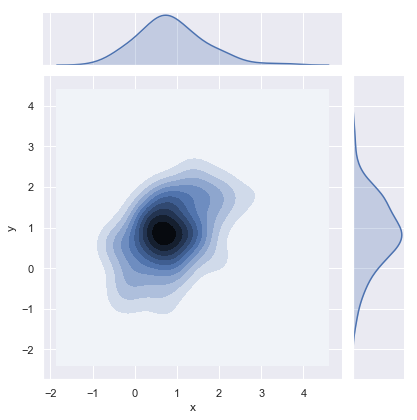

In [218]:
sns.set(color_codes=True)
sns.jointplot(x="x", y="y", data=df_classe1, kind="kde");

In [194]:
classe_2 = np.random.multivariate_normal(mean = [4.0, 6.0], cov = cov_matrix , size = 100 )
df_classe2 = pd.DataFrame(classe_2, columns=['x','y'])

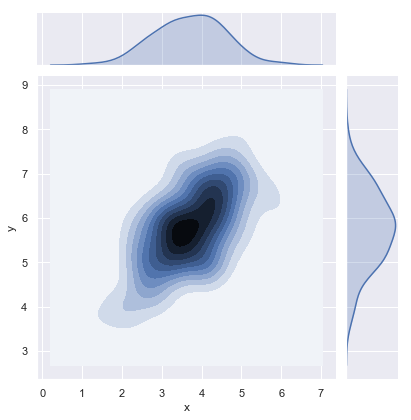

In [195]:
sns.jointplot(x="x", y="y", data=df_classe2, kind="kde");

Irei juntar ambos dataframes que possuem as distribuições da classe 1 e da classe 2 para gerar apenas um dataset.

In [196]:
df = pd.concat([df_classe1, df_classe2])

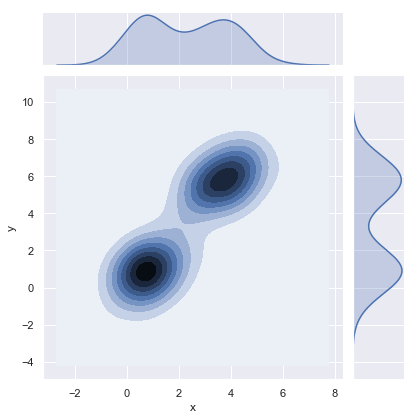

In [197]:
sns.jointplot(x="x", y="y", data=df, kind="kde");

In [198]:
#Colocando o label da classe 1 => 0
df1 = pd.concat([df_classe1, pd.DataFrame( [0]*100, columns=['label'] )], axis = 1)
df1.head()

,x,y,label
0,1.089417,0.142558,0
1,3.627622,2.456033,0
2,0.126933,0.346926,0
3,0.932134,1.025905,0
4,0.849902,1.748750,0


In [199]:
#Colocando o label da classe 2 => 1
df2= pd.concat([df_classe2, pd.DataFrame( [1]*100, columns=['label']  )], axis = 1)
df2.head()

,x,y,label
0,4.562971,6.111591,1
1,1.893092,3.909752,1
2,3.413496,6.257388,1
3,3.183431,5.136616,1
4,4.191803,5.948698,1


In [200]:
data = pd.concat([df1, df2])
#Separando features dos labels
X = data[['x','y']]
X.head()

,x,y
0,1.089417,0.142558
1,3.627622,2.456033
2,0.126933,0.346926
3,0.932134,1.025905
4,0.849902,1.748750


In [201]:
#Separando valores dos labels
Labels = data['label']
Labels.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

b) Implemente o algoritmo perceptron e obtenha a equação da reta de separação

In [205]:
#Classe que implementa perceptron
class Perceptron(object):

    def __init__(self, n_iteracoes=1000, L_rate=0.01 ):
        self.n_iteracoes = n_iteracoes
        self.L_rate = L_rate
        
    def realizar_fit(self, X, y): 
        self.coeficiente_ = np.zeros(X.shape[1])
        self.inter = 0
        self.erros = []
        for _ in range (self.n_iteracoes):
            erro = 0.0
            for xi, v_real in zip (X, y):
                update = self.L_rate * (v_real - self.predicao(xi))
                self.coeficiente_       += update * xi
                self.inter  += update
                erro           += int(update != 0.0)
            self.erros.append (erro)
            
        return self

    def entrada(self, X):
        return np.dot(X, self.coeficiente_) + self.inter

    def predicao (self, X):
        result = self.entrada(X)
        if result < -2:
            return 0
        elif result > 2:
            return 2
        else:
            return 1
        
    def score(self, X, y):
        results = np.array([self.predicao(xi) for xi in X])
        
        return np.sum(results == y) / len(y)

In [206]:
percep = Perceptron( L_rate = 0.3 , n_iteracoes = 1500 )

#vamos utilizar 30% dos dados para ser o conjunto de teste ficando 70% dos dados para treino
X_treino, X_teste, Y_treino, Y_teste = train_test_split(X, Labels,test_size=0.3,random_state=30)

#executar treinamento
modelo_per = percep.realizar_fit( X_treino.values , Y_treino.values )

#verificar o score de classificação
score = modelo_per.score( X_teste.values , Y_teste.values )

print(score)


0.8



c) Utilize a analise de discriminate linear para obter a reta de separação

In [207]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#Esse eu tive que fazer pelo SKlearn, desculpe
lda = LDA(n_components=2)
lda_model = lda.fit(X_treino.values, Y_treino.values)

#verificar score do LDA
lda_model.score( X_teste.values , Y_teste.values )

1.0

In [208]:
lda.scalings_

array([[-0.01296825],
       [ 1.22226712]])

d) Implemente o algoritmo K-NN... Verifique seu comportamento para diferentes valores de K.

In [209]:
import csv
import random
import math
import operator

#Divite um list em dois sets de dados, treino e teste
def divTrainTeste(dataset, train_set=[] , test_set=[]):
    dataset = list(dataset)
    for x in range(len(dataset)-1):
        if 0.6 > random.random() :
            train_set.append(dataset[x])
        else:
            test_set.append(dataset[x])
 

#Calcula a distancia Euclidiana
def euc_dist(x_1, x_2, length):
    distance = 0
    for x in range(length):
        distance += pow((x_1[x] - x_2[x]), 2)
    return math.sqrt(distance)
 
#Procura vizinho mais próximo da instancia
def getVizinhos(train_set, instancia_teste, k):
	distances = []
	length = len(instancia_teste)-1
	for x in range(len(train_set)):
		dist = euc_dist(instancia_teste, train_set[x], length)
		distances.append((train_set[x], dist))
	distances.sort(key=operator.itemgetter(1))
	vizinhos = []
	for x in range(k):
		vizinhos.append(distances[x][0])
	return vizinhos

# devolve a classe da com mais instancias nos vizinhas
def getResp(vizinhos):
	classVotes = {}
	for x in range(len(vizinhos)):
		response = vizinhos[x][-1]
		if response in classVotes:
			classVotes[response] += 1
		else:
			classVotes[response] = 1
	sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
	return sortedVotes[0][0]

#somente verifica a eficiencia (score)
def getAccuracy(test_set, predicoes):
	correct = 0
	for x in range(len(test_set)):
		if test_set[x][-1] == predicoes[x]:
			correct += 1
	return (correct/float(len(test_set))) * 100.0
 


In [217]:
# Utilizando os mesmos dados criados no item a
train_set=[]
test_set=[]
divTrainTeste(data.values, train_set, test_set)

# Verificar predicoes para varios Ks diferentes

for k in [1, 2, 5, 10, 20 ]:
    predicoes=[]
    for x in range(len(test_set)):
        vizinhos = getVizinhos(train_set, test_set[x], k)
        result = getResp(vizinhos)
        predicoes.append(result)
        
    accuracy = getAccuracy(test_set, predicoes)
    print('K ='+ str(k) +' - Score: ' + repr(accuracy) + '%')

K =1 - Score: 96.62921348314607%
K =2 - Score: 96.62921348314607%
K =5 - Score: 100.0%
K =10 - Score: 100.0%
K =20 - Score: 100.0%
